# Data Modelling and Evaluations

With preprocessing and data cleaning from the previous step, we now have a clean dataset that falls in the inclusive range of [0,1]. This helps model to generaize the weights of significantly high values like high age values and some missing values.

In [ ]:
# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

In [432]:
path = './bank_marketing'
data_add = '/data'
report_add = '/report'
figures_add = '/figures'
experiment_add = '/experiments'

In [472]:
# Lets crreate a helper function for plotting confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Import processed data which is ready for modelling

In [433]:
X_over_preprocessed= pd.read_csv(path + data_add + '/processed/Over_processed_features.csv',index_col=0)
y_over_preprocessed= pd.read_csv(path + data_add + '/processed/Over_processed_labels.csv',index_col=0)
X_over_preprocessed.shape, y_over_preprocessed.shape

((73096, 62), (73096, 1))

In [434]:
X_under_preprocessed= pd.read_csv(path + data_add + '/processed/Under_processed_features.csv',index_col=0)
y_under_preprocessed= pd.read_csv(path + data_add + '/processed/Under_processed_labels.csv',index_col=0)
X_under_preprocessed.shape, y_under_preprocessed.shape

((9280, 61), (9280, 1))

In [435]:
X_raw_preprocessed = pd.read_csv(path + data_add +'/processed/Raw_processed_features.csv',index_col=0)
y_raw_preprocessed = pd.read_csv(path + data_add + '/processed/Raw_processed_labels.csv',index_col=0)
X_raw_preprocessed.shape, y_raw_preprocessed.shape

((41188, 62), (41188, 1))

## Data Modelling <a class="anchor" id="seven-bullet"></a>

In [436]:
import time
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

# Assigning dictionary of models
dict_classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}


In [437]:
# Defining a function to test classifiers with 3 fold cross validation to form a baseline performance

no_classifiers = len(dict_classifiers.keys())

def cv_model(X_train,Y_train,verbose = True):
    df_results = pd.DataFrame()
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        cross_val = cross_val_score(classifier,X_train, Y_train, cv = 3)
        t_end = time.clock()
        t_diff = t_end - t_start
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Total_time'] = t_diff
        df_results.loc[count,'Cross Val Mean Score'] = cross_val.mean()
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

### Using Raw Preprocessed Data

In [438]:
cv_raw_results = cv_model(X_raw_preprocessed.values,y_raw_preprocessed.values)
cv_raw_results = cv_raw_results.sort_values(by='Cross Val Mean Score', ascending=False)
print(cv_raw_results)

trained Nearest Neighbors in 46.03 s
trained Random Forest in 15.30 s
trained Gradient Boosting Classifier in 46.45 s
                     Classifier  Total_time  Cross Val Mean Score
2  Gradient Boosting Classifier   46.452167              0.547943
0             Nearest Neighbors   46.026236              0.524270
1                 Random Forest   15.302129              0.395783


<b>Lets evaluate the best performing model on test set</b>

In [439]:
X_train, X_test, y_train, y_test = train_test_split(X_raw_preprocessed, y_raw_preprocessed, test_size=0.20)
best_clf = dict_classifiers.get(cv_raw_results.Classifier.iloc[0])
print(best_clf)
best_clf.fit(X_train,y_train)
y_pred = best_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

GradientBoostingClassifier()
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7301
           1       0.67      0.50      0.57       937

    accuracy                           0.91      8238
   macro avg       0.80      0.73      0.76      8238
weighted avg       0.91      0.91      0.91      8238



In [440]:
X_train.to_csv(path + experiment_add + '/raw_X_train.csv',index = False)
X_test.to_csv(path + experiment_add + '/raw_X_test.csv',index = False)
y_train.to_csv(path + experiment_add + '/raw_y_train.csv',index = False)
y_test.to_csv(path + experiment_add + '/raw_y_test.csv',index = False)
np.savetxt(path + experiment_add + '/raw_y_pred.csv', y_pred, delimiter=",")

### Experiment using Undersampling

In [441]:
cv_under_results = cv_model(X_under_preprocessed,y_under_preprocessed)
cv_under_results = cv_under_results.sort_values(by='Cross Val Mean Score', ascending=False)
print(cv_under_results)

trained Nearest Neighbors in 2.88 s
trained Random Forest in 4.28 s
trained Gradient Boosting Classifier in 7.98 s
                     Classifier  Total_time  Cross Val Mean Score
0             Nearest Neighbors    2.876624              0.603246
2  Gradient Boosting Classifier    7.982241              0.462824
1                 Random Forest    4.278990              0.448276


<b>Lets evaluate the best performing model on test set</b>

In [442]:
X_train, X_test, y_train, y_test = train_test_split(X_under_preprocessed, y_under_preprocessed, test_size=0.20)
best_clf = dict_classifiers.get(cv_under_results.Classifier.iloc[0])
best_clf.fit(X_train,y_train)
y_pred= best_clf.predict(X_test)

In [443]:
print(best_clf)
print(metrics.classification_report(y_test,y_pred))

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       969
           1       0.78      0.72      0.75       887

    accuracy                           0.77      1856
   macro avg       0.77      0.77      0.77      1856
weighted avg       0.77      0.77      0.77      1856



In [444]:
X_train.to_csv(path + experiment_add + '/undersampled_X_train.csv', index = False)
X_test.to_csv(path + experiment_add + '/undersampled_X_test.csv', index = False)
y_train.to_csv(path + experiment_add + '/undersampled_y_train.csv', index = False)
y_test.to_csv(path + experiment_add + '/undersampled_y_test.csv', index = False)
np.savetxt(path + experiment_add + '/undersampled_y_pred.csv', Under_labels, delimiter=",")

### Using Oversampling method

In [445]:
cv_over_results = cv_model(X_over_preprocessed,y_over_preprocessed)
cv_over_results = cv_over_results.sort_values(by='Cross Val Mean Score', ascending=False)
print(cv_over_results)

trained Nearest Neighbors in 128.85 s
trained Random Forest in 20.50 s
trained Gradient Boosting Classifier in 42.25 s
                     Classifier  Total_time  Cross Val Mean Score
2  Gradient Boosting Classifier   42.248165              0.690584
1                 Random Forest   20.504631              0.580676
0             Nearest Neighbors  128.853402              0.557131


In [453]:
X_train, X_test, y_train, y_test = train_test_split(X_over_preprocessed, y_over_preprocessed, test_size=0.20)
best_clf = dict_classifiers.get(cv_over_results.Classifier.iloc[0])
best_clf.fit(X_train,y_train)
over_labels = best_clf.predict(X_test)
print(metrics.classification_report(y_test,over_labels))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      7353
           1       0.86      0.94      0.90      7267

    accuracy                           0.89     14620
   macro avg       0.89      0.89      0.89     14620
weighted avg       0.89      0.89      0.89     14620



In [454]:
X_train.to_csv(path + experiment_add + '/Oversampled_X_train.csv',index= False)
X_test.to_csv(path + experiment_add + '/Oversampled_X_test.csv',index= False)
y_train.to_csv(path + experiment_add + '/Oversampled_y_train.csv',index= False)
y_test.to_csv(path + experiment_add + '/Oversampled_y_test.csv',index= False)
np.savetxt(path + experiment_add + '/Oversampled_y_pred.csv', over_labels, delimiter=",")

## Based on the results obtained I will finetune all 3 models only using the oversampled data. This is party because undersampling eliminates 80% of the data limiting model to generalize. 

<b>Starting with RandomForestClassifier</b>

In [ ]:
# Calling Random Forest Classifier
rfc=RandomForestClassifier(random_state=42)

In [ ]:
# Setting the grid parameters
param_grid = { 
    'n_estimators': np.arange(2,19,3),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy']
}

In [ ]:
# Evaluating the grid parameters
X_train, X_test, y_train, y_test = train_test_split(X_over_preprocessed, y_over_preprocessed, test_size=0.20)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)

In [455]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 11}

In [456]:
finetune_rf = CV_rfc.best_estimator_
finetune_rf.fit(X_test,y_test)
rf_pred = finetune_rf.predict(X_test)


In [457]:
print(metrics.classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7353
           1       0.84      0.93      0.88      7267

    accuracy                           0.88     14620
   macro avg       0.88      0.88      0.87     14620
weighted avg       0.88      0.88      0.87     14620



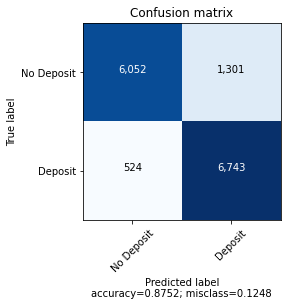

In [474]:
fig = plot_confusion_matrix(metrics.confusion_matrix(y_test,rf_pred), target_names= ['No Deposit', 'Deposit'], normalize=False)
plt.show(fig)

In [ ]:
k_range = list(range(3, 10 ,2))

weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
rand = RandomizedSearchCV(knn, param_dist, cv=3, scoring='accuracy', random_state=5, n_jo)

rand.fit(X_train, y_train)

In [458]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.9279533483822423
{'weights': 'distance', 'n_neighbors': 3}
KNeighborsClassifier(n_neighbors=3, weights='distance')


In [459]:
finetune_rand = rand.best_estimator_
finetune_rand.fit(X_train,y_train)
knn_pred = finetune_rand.predict(X_test)
print(metrics.classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94      7353
           1       0.90      1.00      0.95      7267

    accuracy                           0.95     14620
   macro avg       0.95      0.95      0.95     14620
weighted avg       0.95      0.95      0.95     14620



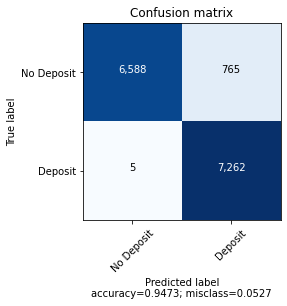

In [475]:
fig = plot_confusion_matrix(metrics.confusion_matrix(y_test,knn_pred), target_names= ['No Deposit', 'Deposit'], normalize=False)
plt.show(fig)

In [ ]:
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

result = clf.predict(X_test)


In [471]:
print(clf.score(X_train, y_train))
print(clf.best_params_)

0.9999315958683904
{'learning_rate': 1, 'max_depth': 9, 'n_estimators': 500}


In [468]:
tune_clf = clf.best_estimator_
tune_clf.fit(X_train,y_train)
GB_pred = tune_clf.predict(X_test)
print(metrics.classification_report(y_test,GB_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      7353
           1       0.95      1.00      0.97      7267

    accuracy                           0.97     14620
   macro avg       0.97      0.97      0.97     14620
weighted avg       0.97      0.97      0.97     14620



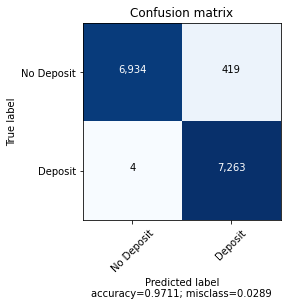

In [476]:
fig = plot_confusion_matrix(metrics.confusion_matrix(y_test,GB_pred), target_names= ['No Deposit', 'Deposit'], normalize=False)
plt.show(fig)

In [461]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators = [("rf",finetune_rf),("knn",finetune_rand),("gnb",tune_clf)], voting = 'hard',n_jobs = -1)
ensemble.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=6,
                                                     n_estimators=11,
                                                     random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=3,
                                                   weights='distance')),
                             ('gnb',
                              GradientBoostingClassifier(learning_rate=1,
                                                         max_depth=9,
                                                         n_estimators=500))],
                 n_jobs=-1)

##  Model Analysis <a class="anchor" id="eight-bullet"></a>

In [462]:
final_preds = ensemble.predict(X_test)

In [463]:
print(metrics.classification_report(y_test,final_preds))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      7353
           1       0.92      1.00      0.96      7267

    accuracy                           0.96     14620
   macro avg       0.96      0.96      0.96     14620
weighted avg       0.96      0.96      0.96     14620



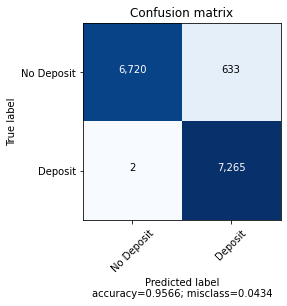

<Figure size 432x288 with 0 Axes>

In [464]:
fig = plot_confusion_matrix(metrics.confusion_matrix(y_test,final_preds), target_names= ['No Deposit', 'Deposit'], normalize=False)
plt.savefig(path + figures_add + '/Ensemble_CM.png')
plt.show(fig)

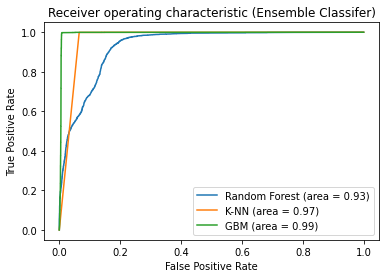

In [469]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

baseline_roc_auc = roc_auc_score(y_test, finetune_rf.predict_proba(X_test)[:,1])
fprB, tprB, thresholdsB = roc_curve(y_test, finetune_rf.predict_proba(X_test)[:,1])

model1_roc_auc = roc_auc_score(y_test, finetune_rand.predict_proba(X_test)[:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, finetune_rand.predict_proba(X_test)[:,1])

new_roc_auc = roc_auc_score(y_test, tune_clf.predict_proba(X_test)[:,1])
fprnew, tprnew, thresholds_new = roc_curve(y_test, tune_clf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='Random Forest (area = %0.2f)' % baseline_roc_auc)
plt.plot(fpr1, tpr1, label='K-NN (area = %0.2f)' % model1_roc_auc)
plt.plot(fprnew, tprnew, label='GBM (area = %0.2f)' % new_roc_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (Ensemble Classifer)')
plt.legend(loc="lower right")
plt.savefig(path + figures_add + '/Roc_curve.png')
plt.show()

### Calculating the feature importances using the best fit random forest classifier

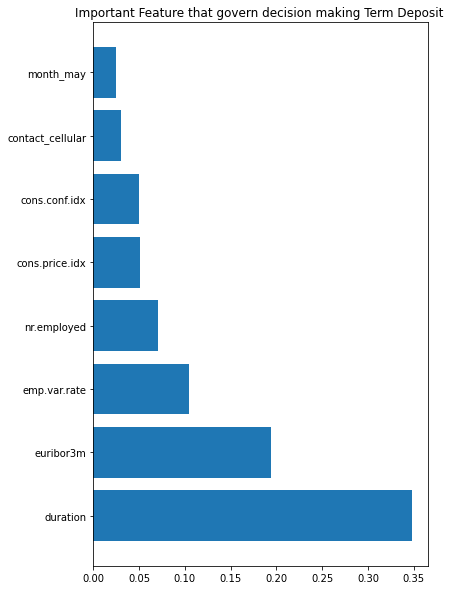

In [470]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize = [6,10])
    plt.title("Important Feature that govern decision making Term Deposit ")
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# passing our column names
feature_names = X_train.columns 

# calling feature importance function to plot the most important features for energy consumption
f_importances((finetune_rf.feature_importances_), feature_names, top=8)

<b> Inferences</b> 
- Based on the modelling, we can infere that our final model generalizes well and can predict majority unseen cases.
- Feature impotances calculated from Random Forests states that Call Duration plays an important factor in decision making for our model.
- Economic data collected in the latest version of the dataset plays a significant factor in predicting customer behavior
- Celluar point of contacts are have high turn out ratio as compared to telephonic connections.

<b> Future Steps</b>

<b> Data and Model Improvements </b>
- As economic attributes tend to play vital role in predicting cutomer behavior, adding more variables from economics and statistics could lead to a better picture.
- Could invest more time and efforts in data cleaning and preprocessing.(For e.g imputation of entire datasaet based on the missing values, eliminating redudant classes in education by binning basic education in one set, etc) 
- Try SMOTE and other advanced sampling techniques to overcome the class imbalance class distribution
- Try other various algorithms and generate inferences based on their performance.
- Once we have hold to additional data, adding more classifiers in the ensemble pipeline could lead to better predictions. 

<b>Summarizing entire pipeline for generating inferences from the steps applied.</b>
- Campaign managers should definitely limit calling same client and direct resources in approaching new customers.
- Based on collected data, groups with university education and those working in Admin, Technical or are retired have higher chacnes of subscribing to term deposits. 
- The model can be enhanced to production level by integrating with doamin experts and developed a system which provides real time analysis to campaign managers such that they can tweak their marketing pitch based on the personalized insights from the data.
- This system can help to reduce the Rejection Rate and optimize resource planning to expand the reach of the marketing campaign.

# Thank You